In [121]:
# packages
import os
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

from sklearn.metrics import recall_score, confusion_matrix, accuracy_score, precision_score

from matplotlib import pyplot as plt

In [54]:
# mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [110]:
df = pd.read_csv('/content/drive/My Drive/ms_wind_curtailment_prediction/lagged_curtailment_target_features.csv', sep = ';', index_col=0)

In [111]:
# Drop the rows to get appropriate test data
df.drop(df.index[-4416:], inplace=True)

In [113]:
# preprocessing pipelines
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

smote = SMOTE(random_state=13)

# create model instance
xgboost_class = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic', random_state = 13)

# features X and target y
X = df.drop(['redispatch', 'level'], axis = 1)
y = df['redispatch']

In [122]:
# cross-validation
n_splits = 16
test_size = 24 #(6h with 15 min intervalls)
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size) #, step=step)

recall_scores = []
precision_scores = []
accuracy_scores = []
conf_matrices = []

for i, (train_index, test_index) in enumerate(tscv.split(X)):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train = X_train.copy()
    X_test = X_test.copy()

    # check if at least one instance of redispatch with status 1 is present in the test data
    if y_test.sum() == 0:
        continue

    # importance of the last redispatch status for the training data
    window_size = 2  # last 30 min
    last_redispatch_importance_train = []
    for i in range(len(y_train)):
        window_start = max(0, i - window_size)
        window_end = i
        importance = y_train.iloc[window_start:window_end].sum() # also incorporate the level
        last_redispatch_importance_train.append(importance)
    X_train['last_redispatch_importance'] = last_redispatch_importance_train

    # rate of decrease for the importance values
    decrease_rate = last_redispatch_importance_train[-1] / len(X_test)

    # forward fill the last value of 'last_redispatch_importance' for the test data with decreasing values
    last_redispatch_importance_test = np.linspace(last_redispatch_importance_train[-1], 0, len(X_test))
    X_test['last_redispatch_importance'] = last_redispatch_importance_test

    # Preprocess and oversample only the training data
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_train_preprocessed, y_train_preprocessed = smote.fit_resample(X_train_preprocessed, y_train)

    # Preprocess the test data
    X_test_preprocessed = preprocessor.transform(X_test)

    # Fit the model on the preprocessed training data
    xgboost_class.fit(X_train_preprocessed, y_train_preprocessed)

    # Make predictions on the preprocessed test data
    y_pred = xgboost_class.predict(X_test_preprocessed)

    # Convert predicted probabilities to binary predictions
    y_pred_binary = [1 if pred > 0.3 else 0 for pred in y_pred]

    #print(y_test.value_counts())
    #print("last redispatch importance: ", X_test['last_redispatch_importance'])

    recall = recall_score(y_test, y_pred)
    recall_scores.append(recall)
    precision = precision_score(y_test, y_pred)
    precision_scores.append(precision)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    conf_matrix = confusion_matrix(y_test, y_pred)
    conf_matrices.append(conf_matrix)

# evaluate
print("Average Recall:", sum(recall_scores) / len(recall_scores))
print("Average Precision:", sum(precision_scores) / len(precision_scores))
print("Average Accuracy:", sum(accuracy_scores) / len(accuracy_scores))
print("Average Confusion Matrix:", sum(conf_matrices) / len(conf_matrices))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Average Recall: 0.3333333333333333
Average Precision: 0.028985507246376812
Average Accuracy: 0.5416666666666666
Average Confusion Matrix: [[12.33333333  7.        ]
 [ 4.          0.66666667]]


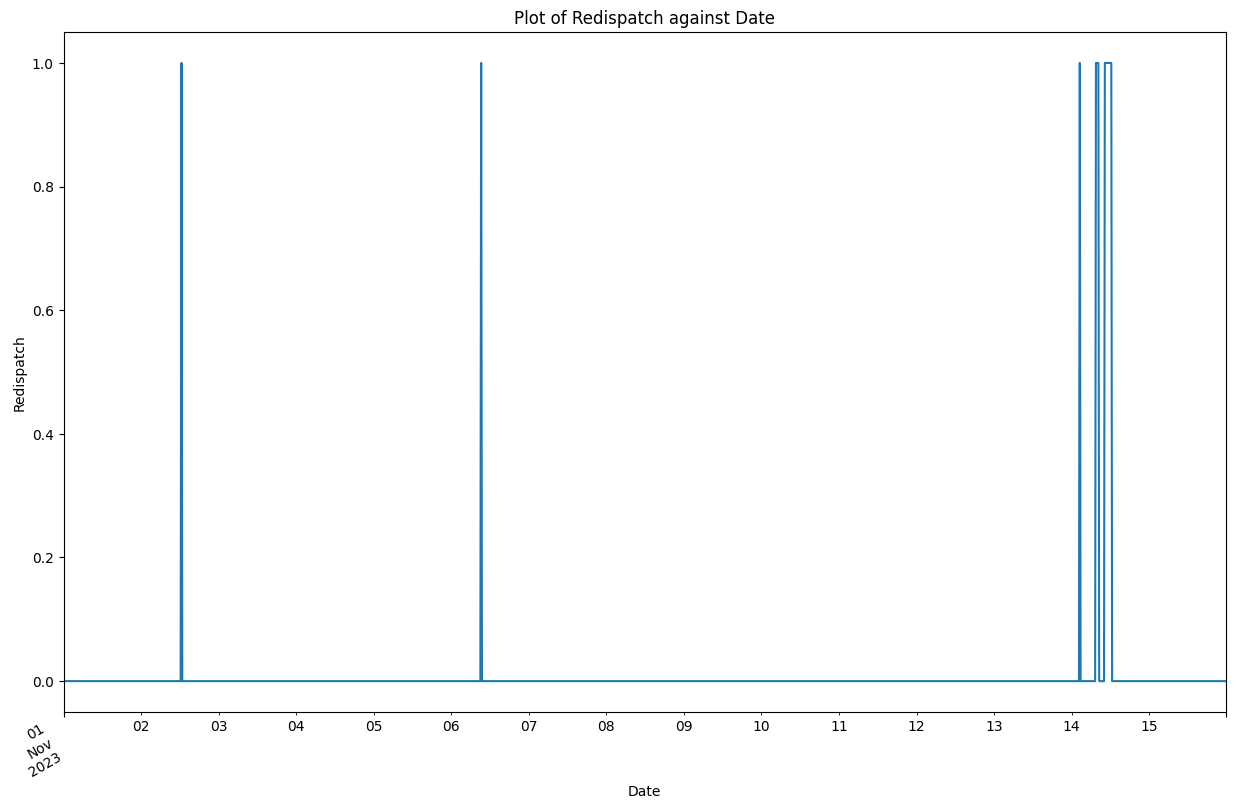

In [67]:
# Plot the column against the datetime index
start_date = '2023-11-01'
end_date = '2023-11-15'

# Plot the data
ax = df.loc[start_date:end_date, 'redispatch'].plot(figsize=(15, 10))

# Customize the x-axis format and limits
plt.gcf().autofmt_xdate()  # Rotate x-axis labels for better readability

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Redispatch')
plt.title('Plot of Redispatch against Date')

# Show the plot
plt.show()